# Explore using DTS data

### Questions:
1) For noisy signals, should we band pass? Smooth?

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [3]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/DarkMix/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/DarkMix/'

dirProj = dirPre + 'proj/exampleDTS/'
dirPrint = dirProj + 'graphics'
dirData = dirProj + 'data'

In [4]:
# First of all, the '°' symbol really messes with the expected encoding. Python 2 silently suppresses these sort of 
# encoding errors. Python 3 now more robustly handles these, but with the downside of requiring slightly more effort
# on my part by explicitly indluding either an encoding or an error message.
os.chdir(dirData + '/CADEX_DTS_data_30s_res')
# f = open('channel 1 20150316 155959 00001.ddf', encoding="latin-1")
# print(f.read())()

### Example of how to robustly read the files.

In case the header length changes across acquisitions, here is a function that starts the read_csv function at the header and data.

It may make sense to keep the header and include it as meta data in a netcdf or something.

In [6]:
def skip_to(fle, line, **kwargs):
    '''
    Inputs:
        fle  = string containing the file's name
        line = line of the header to search for
        **kwargs to pass to pandas read_csv function
        
    Returns:
        pandas dataFrame
    '''
    # Check if the file is empty.
    if os.stat(fle).st_size == 0:
        raise ValueError("File is empty")
    # Read the file using 'latin-1' encoding. Search for specified line.
    with open(fle, encoding="latin-1") as f:
        pos = 0
        cur_line = f.readline()
        # Scan each line until we find the desired header.
        while not cur_line.startswith(line):
            pos = f.tell()
            cur_line = f.readline()
        f.seek(pos)
        # Read the data and close the file.
        return pd.read_csv(f, **kwargs)

df1 = skip_to('channel 1 20150316 155959 00001.ddf', 'length',
              skiprows=0, encoding="latin-1", delimiter='\t', index_col=0)

# Reformat to remove spaces, special, and bad characters
df1.columns = ['temp', 'stokes', 'antistokes']
df1.index.rename('length', inplace=True)

print(df1)

              temp    stokes  antistokes
length                                  
-746.700   -38.034     0.855      -0.392
-745.685   -18.101     1.033      -0.558
-744.671   -97.660     0.654       0.146
-743.656   -97.058     2.015       0.454
-742.642  -126.276     0.249      -0.032
-741.627  -160.322     1.799       0.083
-740.612   -34.424     0.406      -0.192
-739.598  -111.889     1.455       0.252
-738.583    60.598     0.682      -0.584
-737.569   -84.072     1.805       0.493
-736.554    39.734     0.300       0.232
-735.539   -89.621     1.563      -0.394
-734.525    78.156     0.248      -0.228
-733.510   -29.057     0.106      -0.053
-732.496   800.000    -0.028       0.099
-731.481   648.401    -0.204      -0.453
-730.466   382.002    -0.098       0.175
-729.452   -93.562     0.579       0.138
-728.437  -139.281    -0.426      -0.039
-727.423  -147.039     0.162       0.012
-726.408    69.321     0.116      -0.103
-725.394    30.850    -0.369       0.273
-724.379  -157.2

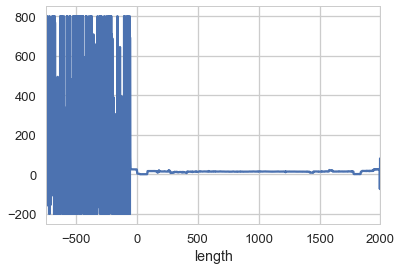

In [8]:
df1.temp.plot()

Holy moly what is happening at the negative lengths.

Ok, now to read two time steps and concat them together

In [9]:
def skip_to(fle, line, **kwargs):
    '''
    Inputs:
        fle  = string containing the file's name
        line = line of the header to search for
        **kwargs to pass to pandas read_csv function
        
    Returns:
        pandas dataFrame
    '''
    # Check if the file is empty.
    if os.stat(fle).st_size == 0:
        raise ValueError("File is empty")
    # Read the file using 'latin-1' encoding. Search for specified line.
    with open(fle, encoding="latin-1") as f:
        pos = 0
        cur_line = f.readline()
        # Scan each line until we find the desired header.
        while not cur_line.startswith(line):
            pos = f.tell()
            cur_line = f.readline()
        f.seek(pos)
        # Read the data and close the file.
        return pd.read_csv(f, **kwargs)

df = skip_to('channel 1 20150316 160059 00001.ddf', 'length',
             skiprows=0, encoding="latin-1", delimiter='\t', index_col=0)

# Reformat to remove spaces, special, and bad characters
df.columns = ['temp', 'stokes', 'antistokes']
df.index.rename('length', inplace=True)

df2 = df
df2 = df2.loc[np.nonzero(df2.index.values >= 0)]
df2.temp = df.temp.where((df.temp < 50) & (df.temp > -50))

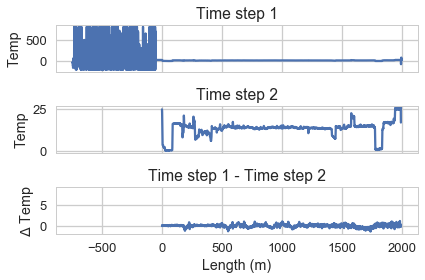

In [10]:
fig, axes = plt.subplots(3, 1, sharex=True)

ax = axes.flatten()[0]
ax.set_title('Time step 1')
ax.plot(df1.index, df1.temp)
ax.set_ylabel('Temp')

ax = axes.flatten()[1]
ax.set_title('Time step 2')
ax.plot(df2.index, df2.temp)
ax.set_ylabel('Temp')

ax = axes.flatten()[2]
ax.set_title('Time step 1 - Time step 2')
ax.plot(df1.index, df1.temp - df2.temp)
ax.set_ylabel('$\Delta$ Temp')
ax.set_xlabel('Length (m)')
fig.tight_layout()

In [11]:
# Code built for remembering how to work with pandas and xarray, specifically concatting
# with a hierarchical multiindex

fname = ['channel 1 20150316 160059 00001.ddf', 'channel 1 20150316 155959 00001.ddf']
keys = []
for f in fname:
    year = int(f.split(' ')[2][0:4])
    month = int(f.split(' ')[2][4:6])
    day = int(f.split(' ')[2][6:8])
    hour = int(f.split(' ')[3][0:2])
    minute = int(f.split(' ')[3][2:4])
    second = int(f.split(' ')[3][4:6])

    dt = pd.datetime(year, month, day, hour, minute, second)
    keys.append(dt) 

df_con = pd.concat([df1, df2], keys=keys, names=['time', 'length'])

ds = xr.Dataset.from_dataframe(df_con)
print(ds)

<xarray.Dataset>
Dimensions:     (length: 2708, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2015-03-16T16:00:59 2015-03-16T15:59:59
  * length      (length) float64 -746.7 -745.7 -744.7 -743.7 -742.6 -741.6 ...
Data variables:
    temp        (time, length) float64 -38.03 -18.1 -97.66 -97.06 -126.3 ...
    stokes      (time, length) float64 0.855 1.033 0.654 2.015 0.249 1.799 ...
    antistokes  (time, length) float64 -0.392 -0.558 0.146 0.454 -0.032 ...


# Alright, let's actually do some processing of data!

In [12]:
# Function for reading DTS output
def skip_to(fle, line, **kwargs):
    '''
    Inputs:
        fle  = string containing the file's name
        line = line of the header to search for
        **kwargs to pass to pandas read_csv function
        
    Returns:
        pandas dataFrame
    '''
    # Check if the file is empty.
    if os.stat(fle).st_size == 0:
        raise ValueError("File is empty")
    # Read the file using 'latin-1' encoding. Search for specified line.
    with open(fle, encoding="latin-1") as f:
        pos = 0
        cur_line = f.readline()
        # Scan each line until we find the desired header.
        while not cur_line.startswith(line):
            pos = f.tell()
            cur_line = f.readline()
        f.seek(pos)
        # Read the data and close the file.
        return pd.read_csv(f, **kwargs)

# Acquire contents of data directory.    
dirCon = os.listdir()
# Only keep list of files that match data file format
dirCon = [ dC for dC in dirCon if 'channel 1' in dC]
ntotal = np.size(dirCon)
# Empty objects to fill later
keys = []
df_con = []

for n, file in enumerate(dirCon):
    if not 'channel 1' in file:
        continue
    else:
        print('Processing file ' + str(n) + ' of ' + str(ntotal), end='\r')
    
    df = skip_to(file, 'length', skiprows=0, encoding="latin-1", delimiter='\t', index_col=0)

    # Reformat to remove spaces, special, and bad characters
    df.columns = ['temp', 'stokes', 'antistokes']
    df.index.rename('length', inplace=True)

    # Remove negative lengths
    df = df.loc[np.nonzero(df.index.values >= 0)]
    # Impose some anticipated physical limits.
    df.temp = df.temp.where((df.temp < 50) & (df.temp > -50))

    year = int(file.split(' ')[2][0:4])
    month = int(file.split(' ')[2][4:6])
    day = int(file.split(' ')[2][6:8])
    hour = int(file.split(' ')[3][0:2])
    minute = int(file.split(' ')[3][2:4])
    second = int(file.split(' ')[3][4:6])

    dt = pd.datetime(year, month, day, hour, minute, second)
    keys.append(dt)

    df_con.append(df)
# Concatenate into a multi index pandas Dataframe
df_con = pd.concat(df_con, keys=keys, names=['time', 'length'])

ds = xr.Dataset.from_dataframe(df_con)
print(ds)

<xarray.Dataset>
Dimensions:     (length: 1972, time: 1000)
Coordinates:
  * time        (time) datetime64[ns] 2015-03-16T15:59:59 ...
  * length      (length) float64 0.042 1.056 2.071 3.086 4.1 5.115 6.129 ...
Data variables:
    temp        (time, length) float64 24.65 22.8 17.07 10.08 4.816 3.551 ...
    stokes      (time, length) float64 2.593e+03 2.613e+03 2.614e+03 ...
    antistokes  (time, length) float64 1.805e+03 1.8e+03 1.741e+03 1.655e+03 ...


### Plot all the data

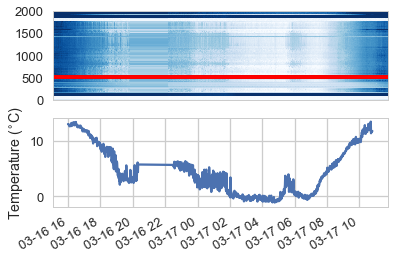

In [13]:
fig, axes = plt.subplots(2, 1)

# Image of data
ax = axes[0]
H = ds.temp.values.astype(float)
H = np.ma.masked_array(H, np.isnan(H))

t = pd.to_datetime(ds.time.values)
Y = ds.length.values.astype(float)
X, Y = np.meshgrid(t, ds.length.values.astype(float))

ax.pcolormesh(X.T, Y.T, H, cmap=cm.Blues, vmin=0, vmax=15)
# Slice the data along a single DTS element
ax.plot([t[0], t[-1]], [Y[500], Y[500]], 'r')
fig.autofmt_xdate()

# Plot the temperature time series
ax = axes[1]
ax.plot(ds.time, ds.temp.isel(length=500))
ax.set_ylabel('Temperature ($^{\circ}$C)')

So I can format and plot the data. Now to assign location descriptors to lengths along the DTS.

In [14]:
location = {
    '-2cm': [273, 410],
    '5cm': [458, 627],
    '10cm 1': [183, 263],
    '10cm 2': [1491, 1578],
    '20cm': [645, 815],
    '50cm': [824, 995],
    '100cm': [1012, 1183],
}
locationHeights = {
    '-2cm': -2,
    '5cm': 5,
    '10cm 1': 10,
    '10cm 2': 10,
    '20cm': 20,
    '50cm': 50,
    '100cm': 100,
}

ds.attrs['arrayHeights'] = [-2, 5, 10, 20, 50, 100] 
ds.coords['height'] = (('length'), np.nan * np.ones(ds.length.size))
for l in location:
    ds.coords['height'].loc[(ds.length > location[l][0]) & (ds.length < location[l][-1])] = locationHeights[l]
print(ds)

<xarray.Dataset>
Dimensions:     (length: 1972, time: 1000)
Coordinates:
  * time        (time) datetime64[ns] 2015-03-16T15:59:59 ...
  * length      (length) float64 0.042 1.056 2.071 3.086 4.1 5.115 6.129 ...
    height      (length) float64 nan nan nan nan nan nan nan nan nan nan nan ...
Data variables:
    temp        (time, length) float64 24.65 22.8 17.07 10.08 4.816 3.551 ...
    stokes      (time, length) float64 2.593e+03 2.613e+03 2.614e+03 ...
    antistokes  (time, length) float64 1.805e+03 1.8e+03 1.741e+03 1.655e+03 ...
Attributes:
    arrayHeights:  [-2, 5, 10, 20, 50, 100]


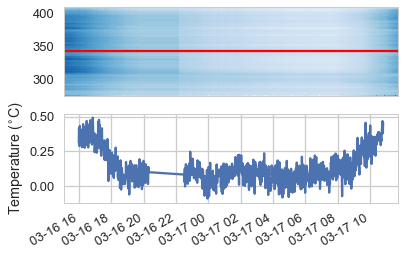

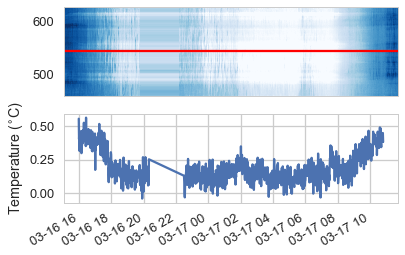

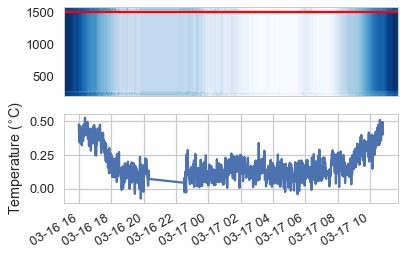

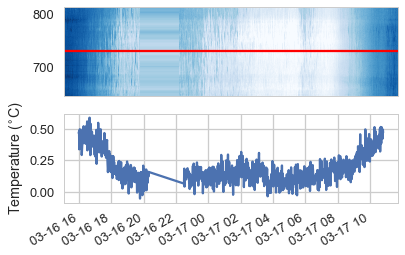

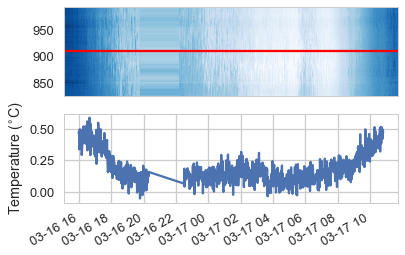

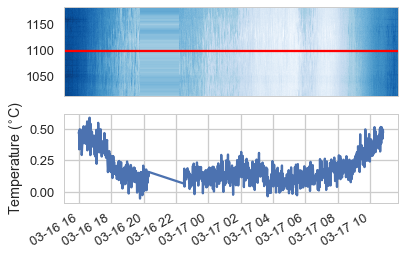

In [15]:
for h in ds.attrs['arrayHeights']:
    fig, axes = plt.subplots(2, 1)

    # Image of data
    ds_height = ds.swap_dims({'length':'height'}).loc[{'height':h}].swap_dims({'height': 'length'})
    ax = axes[0]
    H = ds_height.temp.values.astype(float)
    H = np.ma.masked_array(H, np.isnan(H))

    t = pd.to_datetime(ds_height.time.values)
    length = ds_height.length.values.astype(float) 
    X, Y = np.meshgrid(t, length)

    ax.pcolormesh(X.T, Y.T, H, cmap=cm.Blues, vmin=0, vmax=15)
    # Slice the data along a single DTS element
    ax.plot([t[0], t[-1]], [length[round(length.size / 2)], length[round(length.size / 2)]], 'r')
    fig.autofmt_xdate()

    # Plot the temperature time series
    ax = axes[1]
    ax.plot(ds.time, ds.temp.isel(length=round(length.size / 2)))
    ax.set_ylabel('Temperature ($^{\circ}$C)')

## Further QC considerations
- None uniform attenuation
- Manual vs instrument calibration

In [24]:
def manualCalibration(P_antistokes, P_stokes, dtsTempVector, refTemp1, refTemp2, refTemp3, z1, z2, z3)
# Reference temperatures
T_input = [22, 62.5, 22]
T1 = T_input[0]
T2 = T_input[1]
T3 = T_input[2]

# Reference sections
z_input = [18, 350, 377]
z1 = z_input[0]
z2 = z_input[1]
z3 = z_input[2]

# Amplitudes of stokes/anti-stokes
P_antistokes_input = [3200, 3000, 2275]
P_antistokes_z1 = P_antistokes_input[0]
P_antistokes_z2 = P_antistokes_input[1]
P_antistokes_z3 = P_antistokes_input[2]

P_stokes_input = [3250, 2500, 2350]
P_stokes_z1 = P_stokes_input[0]
P_stokes_z2 = P_stokes_input[1]
P_stokes_z3 = P_stokes_input[2]

# A matrix
A = [[1, -T1, T1*z1],
     [1, -T2, T2*z2],
     [1, -T3, T3*z3],
    ]

# b matrix
b = [[T1 * np.log(P_stokes_z1 / P_antistokes_z1)],
     [T2 * np.log(P_stokes_z2 / P_antistokes_z2)],
     [T3 * np.log(P_stokes_z3 / P_antistokes_z3)],
    ]

x = np.linalg.solve(A, b)

[-0.018  0.134  0.104  0.151  0.188  0.197  0.131  0.164  0.089  0.234
  0.145  0.137  0.203  0.149  0.05   0.137  0.096  0.162  0.195  0.188
  0.198  0.117  0.119  0.153  0.198  0.131  0.1    0.128  0.089  0.157
  0.13  -0.011  0.062  0.112  0.068  0.156  0.073  0.147  0.069  0.059
  0.145  0.171  0.149  0.169  0.036  0.15   0.108  0.083  0.044  0.147
  0.18   0.069  0.119  0.121  0.175  0.194  0.176  0.093  0.104  0.053
  0.052  0.094  0.187  0.173  0.087  0.084  0.136  0.2    0.023  0.177
  0.05   0.199  0.003  0.151  0.184  0.153  0.121  0.094  0.087  0.103
  0.084  0.127  0.164  0.039  0.08   0.083  0.208  0.116  0.227  0.09
  0.203  0.064  0.087  0.092  0.114  0.117  0.118  0.106  0.09   0.294]
